# Browsing History [A Visualization Exercise]

In [30]:
# Import scripts
%matplotlib inline
import pandas as pd
import numpy as np
import json
import datetime
# import pytz
import tldextract
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
plt.style.use('fivethirtyeight')
#plt.style.use('seaborn')

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
# Create dataframe from browser data
with open('BrowserHistory.json', 'r', encoding='utf-8') as f:
    data = json.load(f)
    df = pd.DataFrame(data['Browser History'])

# Data Cleaning

In [4]:
# Remove unnecessary columns  
df.drop('client_id', axis=1, inplace=True)
df.drop('favicon_url', axis=1, inplace=True)

In [5]:
# PAGE-TRANSITION TYPE DEFINITION:
# AUTO_BOOKMARK    User got to this page through a suggestion in the UI.
# AUTO_TOPLEVEL    This is any content that is automatically loaded in a toplevel frame. (ie. homescreen / splash page)
# FORM_SUBMIT      The user filled out values in a form and submitted it.
# GENERATED        User got to this page by typing in the URL bar and selecting an entry that did not look like a URL.
# KEYWORD          The url was generated from a replaceable keyword other than the default search provider.
# LINK             User got to this page by clicking a link on another page.
# RELOAD           The user "reloaded" the page, either by hitting the reload button or by hitting enter in the address bar. 
#                  SessionRestore and undo tab close use this transition type too.
# TYPED            User got this page by typing the URL in the URL bar.

df.groupby(['page_transition']).size()

page_transition
AUTO_BOOKMARK      3336
AUTO_TOPLEVEL      1335
FORM_SUBMIT        5243
GENERATED          5385
KEYWORD              10
LINK             121934
RELOAD             8137
TYPED             11032
dtype: int64

In [6]:
# Convert time_usec to readable datetime format
# Added columns to break out datetime
df['time_usec'] = pd.to_datetime(df['time_usec'],unit='us', utc=True)
df['PST_time'] = df['time_usec'].dt.tz_localize('UTC').dt.tz_convert('America/Vancouver')
df['month'] = df['PST_time'].dt.month
df['hour'] = df['PST_time'].dt.hour
df['day_of_week'] = df['PST_time'].dt.weekday_name
df['weekday'] = df['PST_time'].apply(lambda x: "Y" if x.weekday()<5 else "N")

In [7]:
# Parse URL to get domain information
def get_domain(x):
    if x.startswith('chrome-extension://'):
        return "chrome_extension"
    domain = tldextract.extract(x)[1]
    sub_domain = tldextract.extract(x)[0]
    if domain == "google":
        if sub_domain=="www":
            return "google_search"
        else:
            return sub_domain + "." + domain
    return domain
df['domain'] = df['url'].apply(get_domain)

In [8]:
# Create website categories
def get_category(x):
    if x in ["github", "codecademy", "springboard", "brainstation", "ubc", "coursera", 
             "localhost", "tilda", "getbootstrap", "codeskulptor", "w3schools", "thenounproject", "fontawesome"]:
        return "Coding"
    elif x in ["mail.google", "slack"]:
        return "Email"
    elif x in ["hsbc", "mbna", "americanexpress"]:
        return "Finance"
    elif x in ["vul", "meetup", "eventbrite", "shockwave", "sporcle"]:
        return "Fun"
    elif x in ["linkedin", "angel", "lever", "indeed", "taleo", "ventureloop", "greenhouse"]:
        return "Job"
    elif x in ["feedly", "producthunt","themuse", "medium", "cbc", "techvibes"]:
        return "News"
    elif x in ["toggl", "trello", "calendar.google", "wrike", "asana", "clickup", "keep.google"]:
        return "Productivity"
    elif x in ["amazon", "alibaba", "aritzia", "lululemon", "aliexpress", "groupon"]:
        return "Shopping"
    elif x in ["facebook", "twitter", "instagram", "yelp", "pinterest"]:
        return "Social"
    elif x in ["newtab", "chrome_extension"]:
        return "Tabs"
    elif x in ["youtube", "allrls", "rlsbb", "mega", "openload", "reddit"]:
        return "Video"
    elif x in ["google_search", "wikipedia", "stackoverflow"]:
        return "Search"
    elif x in ["docs.google", "drive.google", "thinkific", "nadagrocery", "odoo", "revelsystems", "airtable", 
               "ikea", "webstaurantstore", "uline", ]:
        return "Work"
    else:
        return "Other"
df['category'] = df['domain'].apply(get_category)

In [9]:
# Breakdown of website categories
df.groupby(['category']).size().sort_values(ascending=False).head(50)

category
Other           48749
Work            21193
Search          14652
News            10592
Tabs            10181
Social           9114
Video            8419
Productivity     6782
Coding           6618
Job              6382
Email            6110
Fun              3530
Shopping         2364
Finance          1726
dtype: int64

In [10]:
# Breakdown of "other" category
df[df['category'] == "Other"].groupby('domain').size().sort_values(ascending=False).head()

domain
analytics.google    466
tjunk               444
adf                 437
pydata              256
hootsuite           250
dtype: int64

In [11]:
# Filter data
df2 = df[['page_transition','title','PST_time', 'month', 'hour', 'day_of_week', 'weekday', 'domain', 'category']]
df2 = df2[((df2['page_transition'] == "LINK") | (df2['page_transition'] == "TYPED") | 
         (df2['page_transition'] == "AUTO_BOOKMARK") | (df2['page_transition'] == "GENERATED")) &
        ((df2['category'] != 'Other') & (df2['category'] != 'Tabs'))]
df2 = df2.reset_index(drop=True)
df2

,page_transition,title,PST_time,month,hour,day_of_week,weekday,domain,category
0,LINK,Keboola: Overview | LinkedIn,2018-02-24 12:55:41.669775-08:00,2,12,Saturday,N,linkedin,Job
1,GENERATED,docker - Google Search,2018-02-24 12:54:03.940090-08:00,2,12,Saturday,N,google_search,Search
2,LINK,www.google.com,2018-02-24 12:48:29.573838-08:00,2,12,Saturday,N,google_search,Search
3,GENERATED,google takeout - Google Search,2018-02-24 12:48:19.314535-08:00,2,12,Saturday,N,google_search,Search
4,LINK,Google Takeout - Wikipedia,2018-02-24 12:47:51.152336-08:00,2,12,Saturday,N,wikipedia,Search
5,GENERATED,google takeout - Google Search,2018-02-24 12:47:19.464838-08:00,2,12,Saturday,N,google_search,Search
6,LINK,Dropbox/courses/Takeout/,2018-02-24 12:45:36.420593-08:00,2,12,Saturday,N,localhost,Coding
7,LINK,Dropbox/courses/,2018-02-24 12:45:30.924666-08:00,2,12,Saturday,N,localhost,Coding
8,LINK,Dropbox/,2018-02-24 12:45:28.821879-08:00,2,12,Saturday,N,localhost,Coding
9,LINK,Authorize | LinkedIn,2018-02-24 12:40:33.005471-08:00,2,12,Saturday,N,linkedin,Job


# Visualizations

## Daily Searches

In [61]:
daily_clicks = df2.groupby([df2['PST_time'].dt.date]).size()
#daily_clicks.head()

daily_search = df2[df2['category']=='Search'].groupby([df2['PST_time'].dt.date]).size()
#daily_search.head()

daily = pd.concat([daily_clicks, daily_search], axis=1, keys=['clicks','search']).reset_index()
daily.head()

,index,clicks,search
0,2017-02-20,399,11.0
1,2017-02-21,148,7.0
2,2017-02-22,404,37.0
3,2017-02-23,304,29.0
4,2017-02-24,296,50.0


Text(0,0.5,'count')

Text(0.5,1,'Daily Clicks')

<Container object of 367 artists>

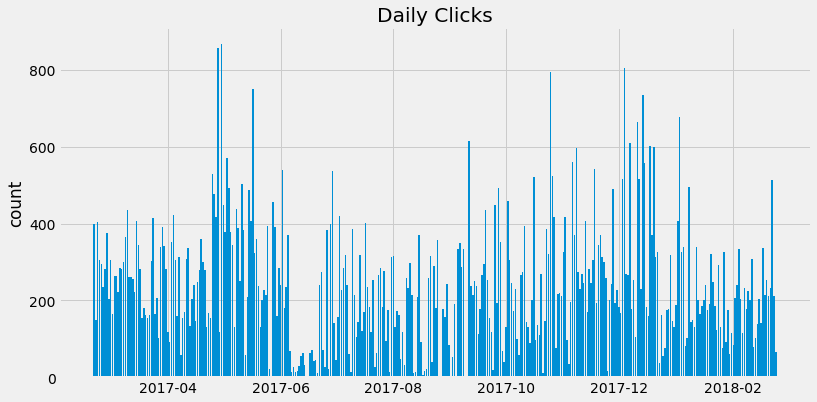

In [146]:
fig, ax = plt.subplots(figsize=(12, 6));
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2));
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'));
plt.ylabel('count');
plt.title('Daily Clicks');
plt.bar(daily['index'], daily['clicks']);

Text(0,0.5,'count')

Text(0.5,1,'Daily Searches')

<Container object of 367 artists>

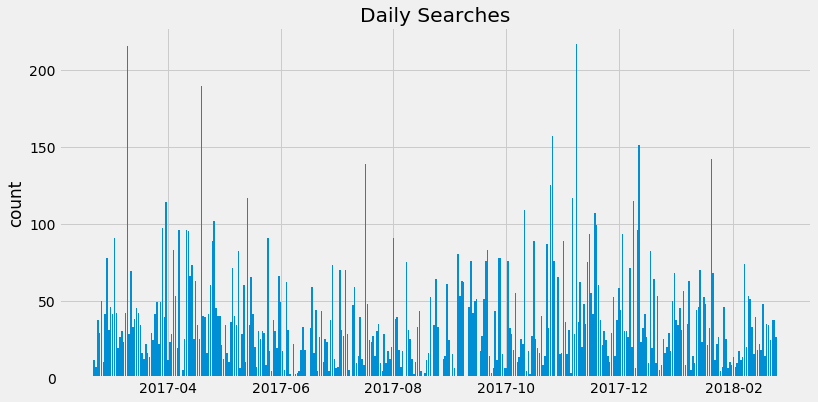

In [147]:
fig, ax = plt.subplots(figsize=(12, 6));
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2));
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'));
plt.ylabel('count');
plt.title('Daily Searches');
plt.bar(daily['index'], daily['search']);

<Container object of 367 artists>

Text(0,0.5,'Click Count')

Text(0,0.5,'Search to Click Ratio')

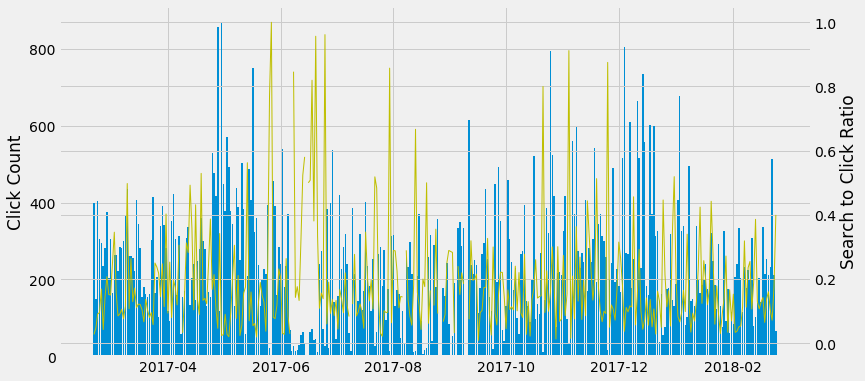

In [148]:
fig, ax = plt.subplots(figsize=(12, 6));
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2));
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'));


plt.bar(daily['index'], daily['clicks']);
plt.ylabel('Click Count');

ax2 = ax.twinx();
ax2.plot(daily['index'], daily['search']/daily['clicks'], color='y',linewidth=1);
ax2.set_ylabel('Search to Click Ratio');

## Weekend vs Weekday

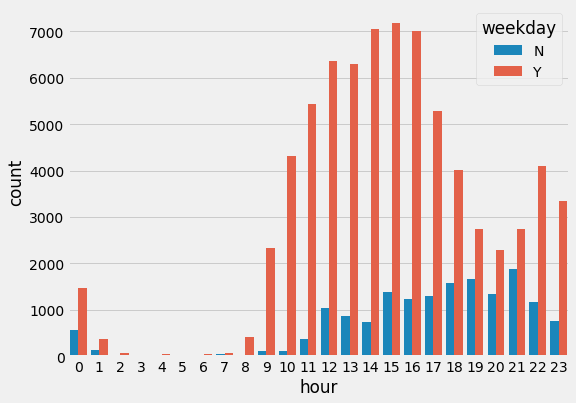

In [149]:
plt.figure(figsize = (8,6));
sns.countplot(x='hour', hue='weekday', data=df2);

# same plot using matplotlib
# df2.groupby(['hour','weekday']).size().unstack().plot.bar(figsize=(8,6))

## Browsing by Month

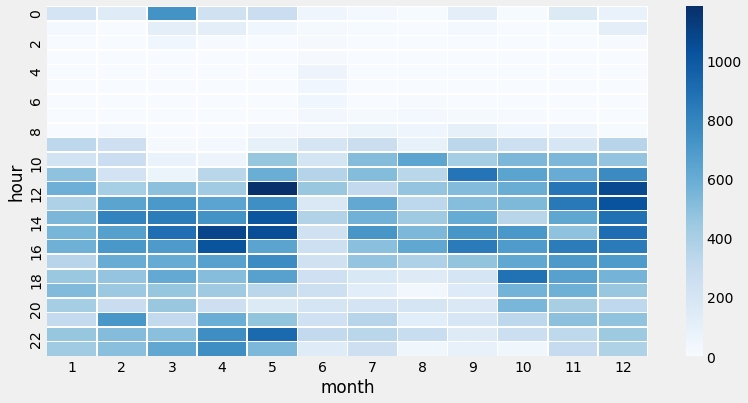

In [151]:
pivot_table = df2.groupby(['hour', 'month']).size().unstack('month', fill_value=0)
pivot_table;
plt.figure(figsize=(12,6));
sns.heatmap(pivot_table, linewidths=.5, annot=False, cmap='Blues');

## Browsing by Day of Week

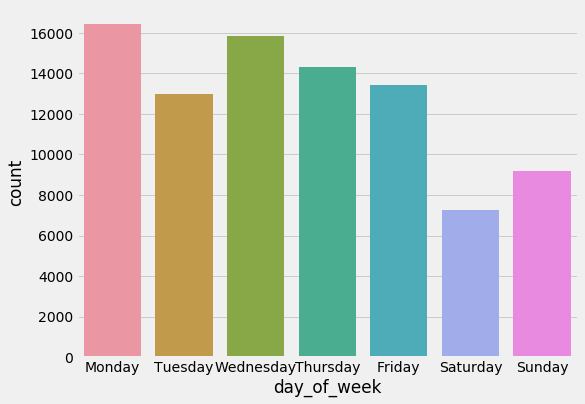

In [152]:
plt.figure(figsize = (8,6));
sns.countplot(x="day_of_week", data=df2, order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]);

In [17]:
pivot_table2 = df2.groupby(['hour', 'day_of_week']).size().unstack('day_of_week', fill_value=0)
pivot_table2 = pivot_table2[["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]]
pivot_table2

day_of_week,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
hour,,,,,,,
0,224,192,361,334,366,306,268
1,119,111,26,79,33,96,44
2,11,32,23,1,0,0,6
3,4,1,10,0,2,0,4
4,0,21,17,21,1,0,5
5,8,2,3,0,2,3,27
6,10,13,1,19,2,1,6
7,14,15,17,11,6,32,18
8,130,146,82,41,13,25,3


In [18]:
pivot_table3 = df2.groupby(['day_of_week','category']).size().unstack('day_of_week', fill_value=0)
pivot_table3 = pivot_table3[["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]]
pivot_table3

day_of_week,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
category,,,,,,,
Coding,736,764,801,787,1002,1084,681
Email,1245,1053,933,996,486,311,319
Finance,124,83,165,120,242,135,141
Fun,748,374,454,404,308,289,422
Job,1108,794,1100,768,630,667,771
News,1744,1334,1712,1490,1910,1044,1129
Productivity,1292,1288,1235,1503,799,161,124
Search,2058,2108,2483,1960,2056,1302,1572
Shopping,498,343,360,161,395,107,206


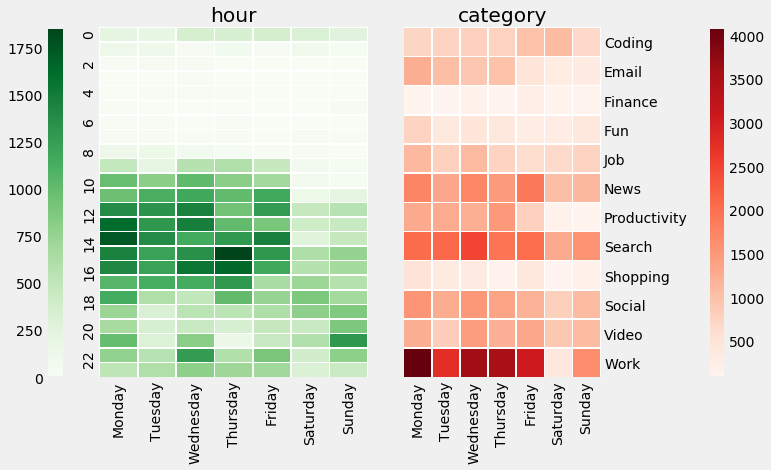

In [154]:
fig, (ax1,ax2) = plt.subplots(figsize=(12,6), ncols=2);
fig.subplots_adjust(wspace=0.1);

sns.heatmap(pivot_table2, linewidths=.5, ax=ax1, annot=False, cbar=False, cmap='Greens');
sns.heatmap(pivot_table3, linewidths=.5, ax=ax2, annot=False, cbar=False, cmap='Reds');
fig.colorbar(ax1.collections[0], ax=ax1,location="left", use_gridspec=False);
fig.colorbar(ax2.collections[0], ax=ax2,location="right", use_gridspec=False, pad=0.3);

ax1.xaxis.label.set_visible(False);
ax2.xaxis.label.set_visible(False);
ax1.yaxis.label.set_visible(False);
ax2.yaxis.label.set_visible(False);

ax2.yaxis.tick_right();
ax2.tick_params(axis='y',rotation=0);

ax1.set_title('hour');
ax2.set_title('category');

## Categories by Month

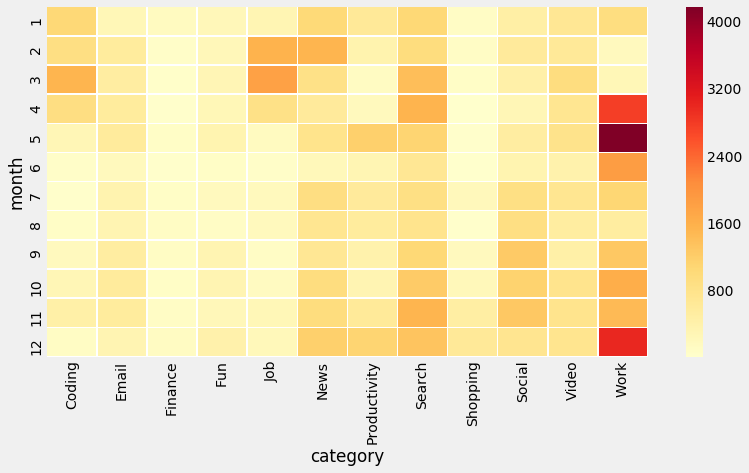

In [155]:
pivot_table4 = df2.groupby(['month','category']).size().unstack('category', fill_value=0)

plt.figure(figsize=(12,6));
sns.heatmap(pivot_table4, linewidths=.5, annot=False, cmap='YlOrRd');

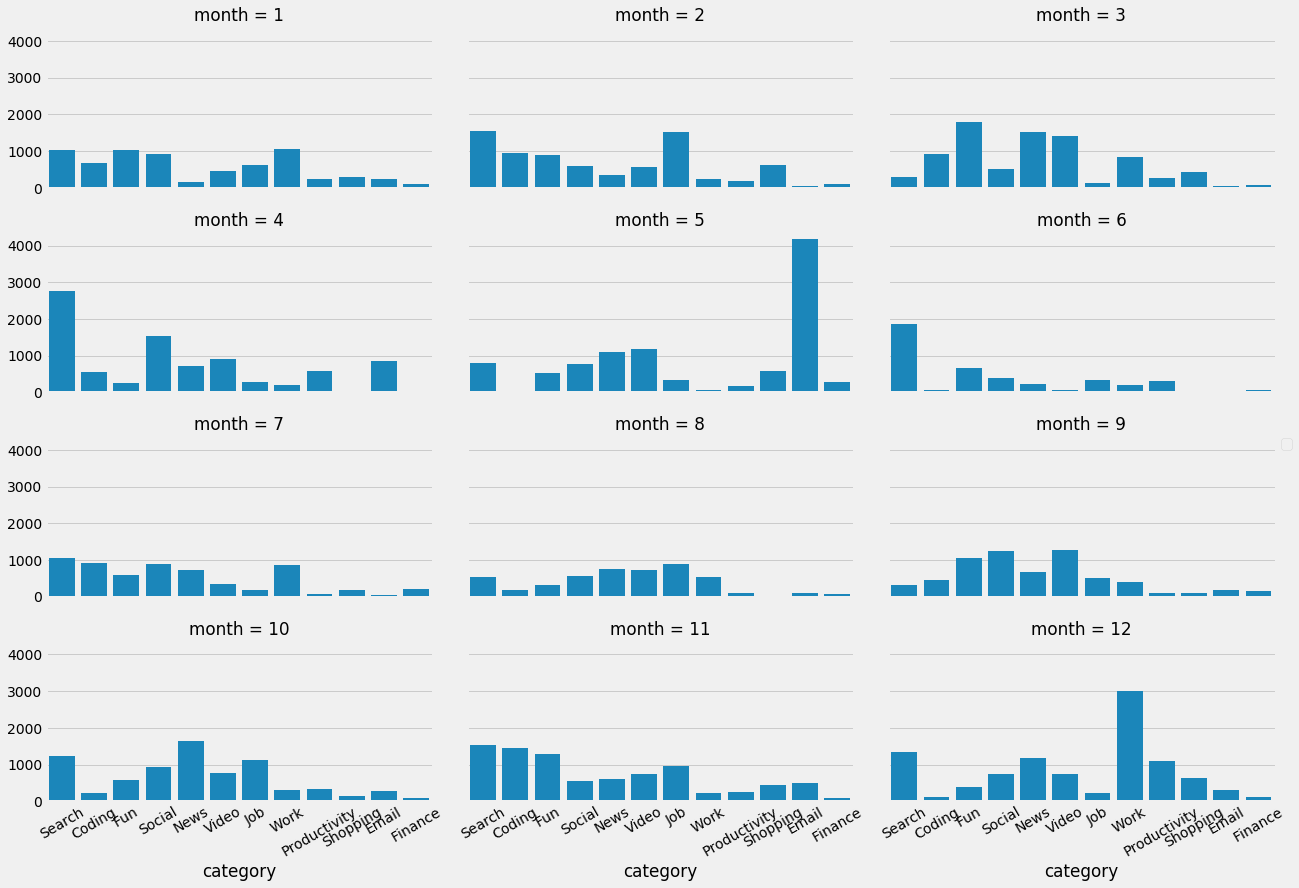

In [21]:
g = sns.FacetGrid(df2, col="month", col_wrap=3, aspect=2).map(sns.countplot, "category").add_legend();
g.set_xticklabels(rotation=30);

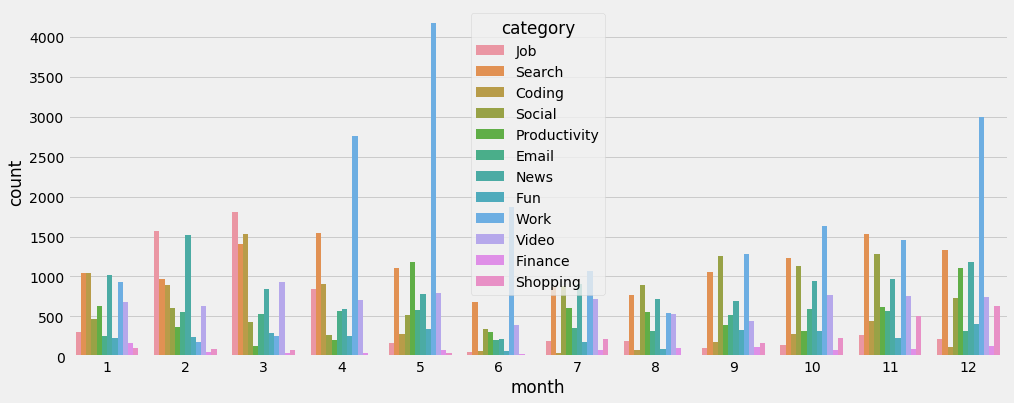

In [22]:
plt.figure(figsize=(15,6));
ax = sns.countplot(x="month", hue="category", data=df2);

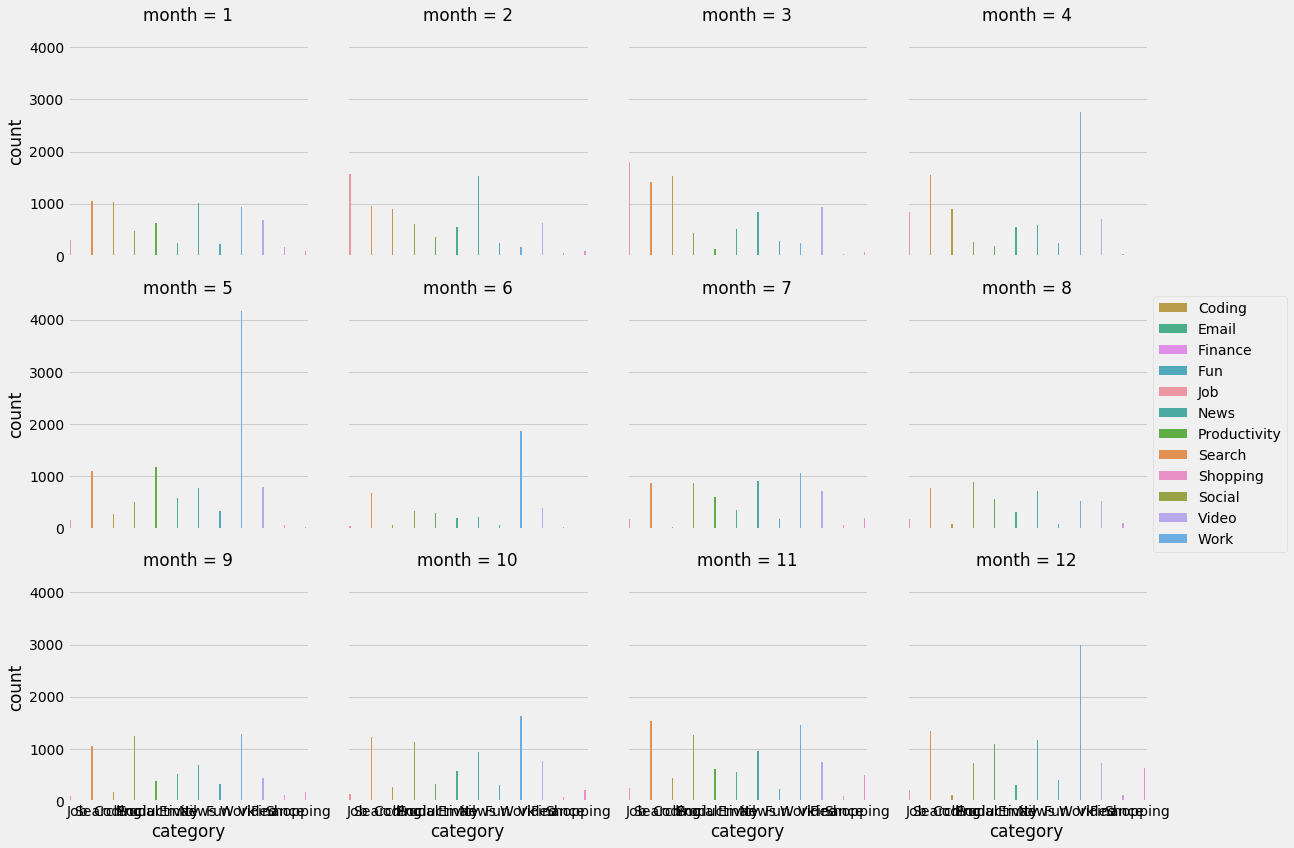

In [23]:
plt.figure(figsize=(12,6));
sns.factorplot(x="category", hue="category", col="month", data=df2, kind="count", col_wrap=4, size=4, aspect=1).add_legend();

## Word Cloud of Search History

(-0.5, 399.5, 199.5, -0.5)

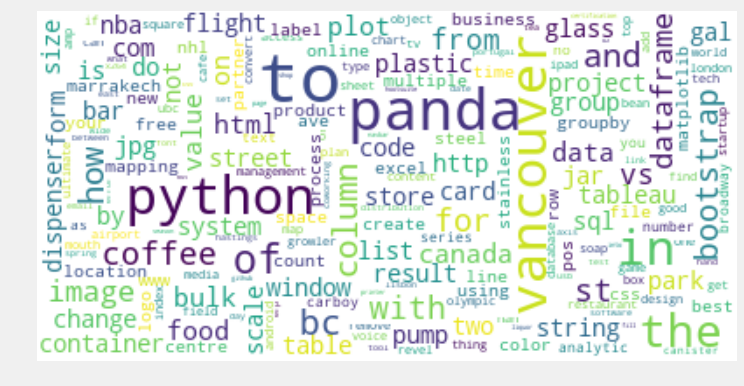

In [156]:
from collections import OrderedDict
search = df2[df2['category']=='Search']['title'].str.lower() \
        .str.split().apply(lambda x: OrderedDict.fromkeys(x).keys()).str.join(' ')

search_title = " ".join(search)
stopwords = ['google', 'search', 'stack', 'overflow', 'wikipedia', 'maps', 'v5z 3g5', 'v5z', '3g5', 'ash']
wc1 = WordCloud(stopwords=stopwords, max_font_size=40, collocations=False, regexp=None, background_color="white")\
            .generate(search_title);


# Display the generated image:
plt.figure(figsize=(12,6));
plt.imshow(wc1, interpolation='bilinear');
plt.axis("off");
plt.margins(x=0, y=0);

## Word Cloud of Domain Visits

(-0.5, 399.5, 199.5, -0.5)

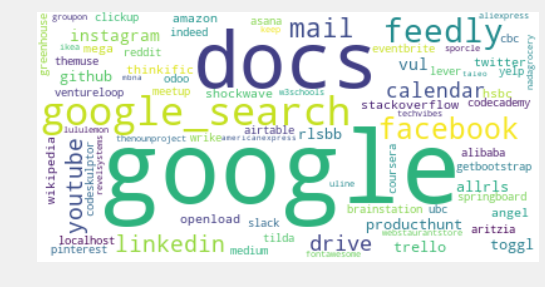

In [157]:
#from collections import OrderedDict
domains = df2['domain'].str.lower() \
        .str.split().apply(lambda x: OrderedDict.fromkeys(x).keys()).str.join(' ')

domain_title = " ".join(domains)
stopwords = []
wc2 = WordCloud(stopwords=stopwords, collocations=False, regexp=None, background_color="white").generate(domain_title);


# Display the generated image:
plt.figure(figsize=(8,6));
plt.imshow(wc2, interpolation='bilinear');
plt.axis("off");
plt.margins(x=0, y=0);
plt.savefig('plots/word_domain')

## References:

* https://seaborn.pydata.org/api.html
* https://chrisalbon.com/python/data_visualization/seaborn_color_palettes/
* https://github.com/daerty0153/visualize-browser-history/blob/master/BrowserHistory.ipynb